ODR Serial Bias and Reference Bias
==================================



## Notebook Settings



In [1]:
%load_ext autoreload
  %autoreload 2
  %reload_ext autoreload

  %run ../notebooks/setup.py
  %matplotlib inline
  %config InlineBackend.figure_format = 'png'

  REPO_ROOT = "/home/leon/models/NeuroFlame"
  pal = sns.color_palette("tab10")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Python exe
/home/leon/mambaforge/envs/torch/bin/python

## Imports



In [1]:
import torch
  import torch.nn as nn
  import torch.optim as optim
  import torch.nn.functional as F
  from torch.utils.data import Dataset, TensorDataset, DataLoader
  from scipy.stats import binned_statistic

In [1]:
import sys
  sys.path.insert(0, '../')

  import pandas as pd
  import torch.nn as nn
  from time import perf_counter
  from scipy.stats import circmean

  from src.network import Network
  from src.plot_utils import plot_con
  from src.decode import decode_bump, circcvl, decode_bump_torch
  from src.lr_utils import masked_normalize, clamp_tensor, normalize_tensor

In [1]:
import pickle as pkl
  import os

  def pkl_save(obj, name, path="."):
      os.makedirs(path, exist_ok=True)
      destination = path + "/" + name + ".pkl"
      print("saving to", destination)
      pkl.dump(obj, open(destination, "wb"))


  def pkl_load(name, path="."):
      source = path + "/" + name + '.pkl'
      print('loading from', source)
      return pkl.load(open( source, "rb"))

## Helpers



In [1]:
def add_vlines(model, ax=None):

    if ax is None:
        for i in range(len(model.T_STIM_ON)):
            plt.axvspan(model.T_STIM_ON[i], model.T_STIM_OFF[i], alpha=0.25)
    else:
        for i in range(len(model.T_STIM_ON)):
            ax.axvspan(model.T_STIM_ON[i], model.T_STIM_OFF[i], alpha=0.25)

In [1]:
import torch
import numpy as np

def generate_weighted_phase_samples(N_BATCH, angles, preferred_angle, sigma):
    # Convert angles list to a tensor
    angles_tensor = torch.tensor(angles)

    # Calculate Gaussian probability distribution centered at preferred_angle
    probs = np.exp(-0.5 * ((angles - preferred_angle) / sigma) ** 2)
    probs /= probs.sum()  # Normalize to get probabilities

    # Create a categorical distribution from the computed probabilities
    distribution = torch.distributions.Categorical(torch.tensor(probs))

    # Sample from the distribution
    indices = distribution.sample((N_BATCH,))

    # Map indices to angles and reshape to (N_BATCH, 1)
    phase_samples = angles_tensor[indices].reshape(N_BATCH, 1)

    return phase_samples

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def continuous_biased_phases(N_BATCH, preferred_angle, sigma):
    # Generate samples from a normal distribution using PyTorch
    phase_samples = torch.normal(mean=preferred_angle, std=sigma, size=(N_BATCH, 1))

    # Normalize angles to the range [0, 360)
    phase_samples = phase_samples % 360

    return phase_samples

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def continuous_bimodal_phases(N_BATCH, preferred_angle, sigma):
    # Sample half from preferred_angle and half from preferred_angle + 180
    half_batch = N_BATCH // 2

    # Sample from preferred_angle
    samples_1 = torch.normal(mean=preferred_angle, std=sigma, size=(half_batch, 1))

    # Sample from preferred_angle + 180
    samples_2 = torch.normal(mean=(preferred_angle + 180) % 360, std=sigma, size=(N_BATCH - half_batch, 1))

    # Combine samples and wrap around 360
    phase_samples = torch.cat((samples_1, samples_2), dim=0) % 360

    return phase_samples

# Example usage
# N_BATCH = 500
# preferred_angle = 45
# sigma = 45

# samples = continuous_bimodal_phases(N_BATCH, preferred_angle, sigma)

# plt.hist(samples.numpy(), bins='auto', density=True)
# plt.xlabel('Phase (degrees)')
# plt.ylabel('Probability Density')
# plt.title('Bimodal Distribution of Phases')
# plt.show()

## Model



In [1]:
REPO_ROOT = "/home/leon/models/NeuroFlame"
conf_name = "test_odr_EI.yml"
DEVICE = 'cuda:1'
seed = np.random.randint(0, 1e6)

seed = 1
print('seed', seed)

IF_BIASED_PHASES = 0
IF_BIAS = 0

IF_RAND_REF = 0
reference = 90
sigma = 60

print('reference', reference, 'sigma', sigma)

if IF_RAND_REF:
    reference = np.random.randint(0, 360)

if IF_BIASED_PHASES:
    class_weight = 'balanced'
else:
    class_weight = None

seed 1
reference 90 sigma 60

In [1]:
N_BATCH = 512
model = Network(conf_name, REPO_ROOT, VERBOSE=0, DEVICE=DEVICE, SEED=seed, N_BATCH=1)

In [1]:
import torch
import math

def periodic_gaussian(x, mean, std, period):
    # Ensure x is a tensor
    if not isinstance(x, torch.Tensor):
        x = torch.tensor(x, dtype=torch.float32)

    # Compute the periodic Gaussian
    adjusted_x = torch.fmod(x - mean + period / 2, period) - period / 2
    gaussian = torch.exp(-0.5 * (adjusted_x / std) ** 2)
    normalization_factor = 1 / (std * math.sqrt(2 * math.pi))

    return gaussian * normalization_factor

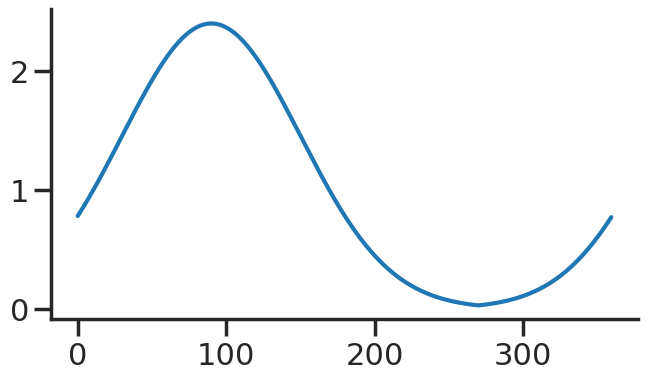

In [1]:
def gaussian_weights(targets, reference, sigma):
      delta = targets - reference
      delta = torch.remainder(delta + torch.pi, 2.0 * torch.pi) - torch.pi
      # delta = (delta + torch.pi) % (2 * torch.pi) - torch.pi
      weights = torch.exp(-0.5 * torch.abs(delta / sigma)**2) # / sigma / torch.sqrt(torch.tensor(2.0 * torch.pi))
      weights = weights / weights.mean(dim=0)
      return weights

theta = torch.linspace(0, 2.0 * torch.pi, model.Na[0]+1)[:-1].to(DEVICE)
weights = gaussian_weights(theta, reference * torch.pi / 180.0, sigma * torch.pi / 180.0)
plt.plot(theta.cpu().numpy() * 180 / np.pi, weights.cpu().numpy()) ;

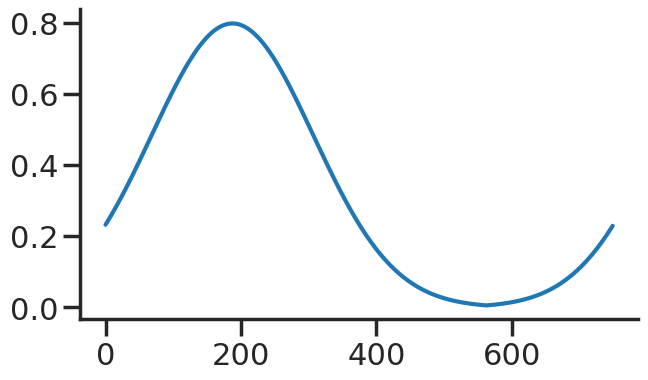

In [1]:
theta = torch.linspace(0, 2.0 * torch.pi, model.Na[0]+1)[:-1].to(DEVICE)

theta_0 = reference * torch.pi / 180.0
sigma_0 = 1.0 #  sigma * torch.pi / 180.0
period = 2.0 * torch.pi

thresh = 2.0 * periodic_gaussian(theta, theta_0, sigma_0, period)
plt.plot(thresh.cpu())
plt.show()

# model.thresh[0, model.slices[0]] = thresh

In [1]:
if IF_BIASED_PHASES:
    print('Biased ODR')
    if IF_RAND_REF:
        print('models/odr/odr_bias_rand_ref_%d.pth' % seed)
        model_state_dict = torch.load('models/odr/odr_bias_rand_ref_%d.pth' % seed)
    else:
        if class_weight=='balanced':
            model_state_dict = torch.load('models/odr/odr_bias_%d_ref_%d_bal_loss.pth' % (reference, seed) )
        else:
            model_state_dict = torch.load('models/odr/odr_bias_%d_ref_%d.pth' % (reference, seed) )
else:
    model_state_dict = torch.load('models/odr/odr_%d.pth' % seed)

model.load_state_dict(model_state_dict)
model.eval()

Network(
  (dropout): Dropout(p=0.0, inplace=False)
)

## Batching Inputs



In [1]:
model.N_BATCH = N_BATCH

if IF_BIASED_PHASES:
    model.PHI0 = torch.zeros(size=(N_BATCH, 3, 1), device=DEVICE, dtype=torch.float)
    model.PHI0[:, 0] = continuous_biased_phases(N_BATCH, reference, sigma)
    model.PHI0[:, -1] = continuous_biased_phases(N_BATCH, reference, sigma)

    # model.PHI0[:, 0] = continuous_bimodal_phases(N_BATCH, reference, sigma)
    # model.PHI0[:, -1] = continuous_bimodal_phases(N_BATCH, reference, sigma)
else:
    model.PHI0 = torch.randint(low=0, high=360, size=(N_BATCH, 3, 1), device=DEVICE, dtype=torch.float)

ff_input = model.init_ff_input()

m0, m1, phase = decode_bump_torch(ff_input[..., model.slices[0]], axis=-1)

torch.Size([1, 750]) torch.Size([512, 1])
torch.Size([1, 750]) torch.Size([512, 1])
torch.Size([1, 750]) torch.Size([512, 1])

90 42.00000116875648 39.383314716589574


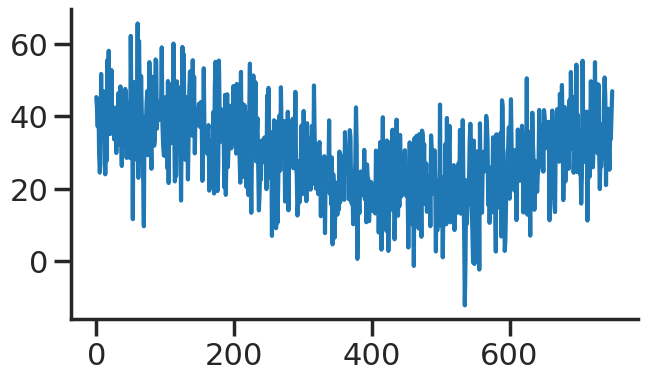

In [1]:
print(reference, model.PHI0[1, 0, 0].item() * 180 / torch.pi, phase[1, model.N_STIM_ON[0]].item() * 180 / torch.pi)
plt.plot(ff_input[1, model.N_STIM_ON[0], model.slices[0]].cpu().numpy())
plt.show()

tensor(134.0000)


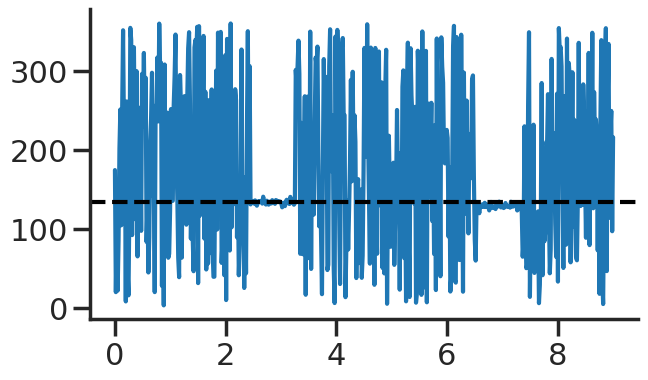

In [1]:
idx = np.random.randint(32)
xtime = np.linspace(0, model.DURATION, phase.shape[-1])
plt.plot(xtime, phase[idx].cpu().detach().numpy() * 180 / np.pi)
plt.axhline(model.PHI0[idx,0,0].cpu() * 180/np.pi, color='k', ls='--')

print(model.PHI0[idx, 0, 0].cpu()*180/np.pi)
# print(phase[idx, window_size].cpu().detach().numpy() * 180 / np.pi)
plt.show()

In [1]:
# model.N_BATCH = 96
# ff_input = []
# labels = []

# phase_list =  torch.tensor([  0.,  45.,  90., 135., 180., 225., 270., 315.], device=DEVICE)

# model.PHI0 = torch.ones((model.N_BATCH, 3, 1), device=DEVICE, dtype=torch.float
#                         )

# for i in range(len(phase_list)):
#     model.PHI0[:, 0] = phase_list[i]
#     model.PHI0[:, -1] = phase_list[torch.randint(0, len(phase_list), (model.N_BATCH,))].unsqueeze(1)

#     label0 = torch.ones(model.N_BATCH, device=DEVICE, dtype=torch.float) * model.PHI0[:, 0, 0] * torch.pi / 180.0
#     label1 = torch.ones(model.N_BATCH, device=DEVICE, dtype=torch.float) * model.PHI0[:, -1, 0] * torch.pi / 180.0

#     labels.append(torch.vstack((label0, label1)))
#     ff_input.append(model.init_ff_input())

# labels = torch.hstack(labels).T
# ff_input = torch.vstack(ff_input)
# print('ff_input', ff_input.shape, 'labels', labels.shape)
# PHI0 = labels.unsqueeze(-1)

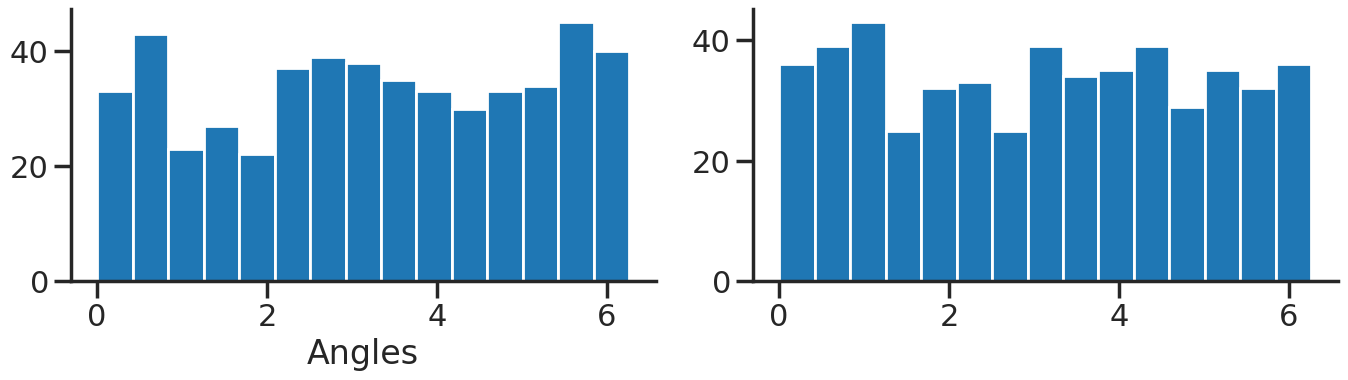

In [1]:
fig, ax = plt.subplots(1, 2, figsize=[2*width, height])
ax[0].hist(model.PHI0[:, 0, 0].cpu(), bins=15)
ax[1].hist(model.PHI0[:,-1, 0].cpu(), bins=15)
ax[0].set_xlabel('Angles')
plt.show()

In [1]:
rates_tensor = model.forward(ff_input=ff_input)# [..., ::3]
rates = rates_tensor.cpu().detach().numpy()
print('rates', rates.shape)

rates (512, 226, 750)

In [1]:
m0, m1, phi = decode_bump(rates, axis=-1)
# m0, m1, phi = get_fourier_moments(rates, axis=-1)
# m0, m1, phi = compute_fourier_moments(rates, dim=-1)
# print(phi.shape)

In [1]:
if IF_BIAS:
    print('bias')
    pkl_save(phi, 'phase_bias', path="/home/leon/")
else:
    pkl_save(phi, 'phase', path="/home/leon/")

saving to /home/leon//phase.pkl

tensor(297.0000)


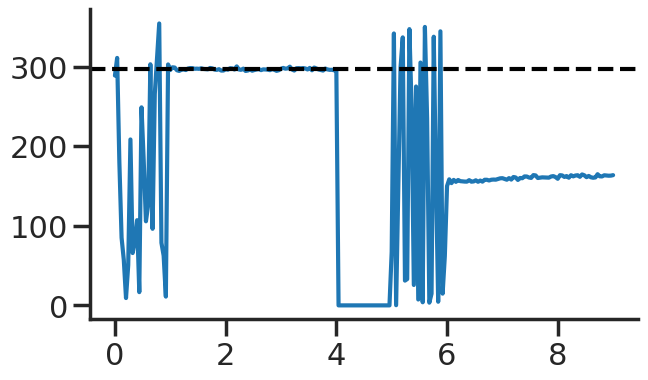

In [1]:
idx = np.random.randint(32)
xtime = np.linspace(0, model.DURATION, phi.shape[-1])
plt.plot(xtime, phi[idx]* 180 / np.pi)
plt.axhline(model.PHI0[idx,0,0].cpu() * 180/np.pi, color='k', ls='--')

print(model.PHI0[idx, 0, 0].cpu()*180/np.pi)
# print(phi[idx, window_size]* 180 / np.pi)
plt.show()

## Results



### Rates



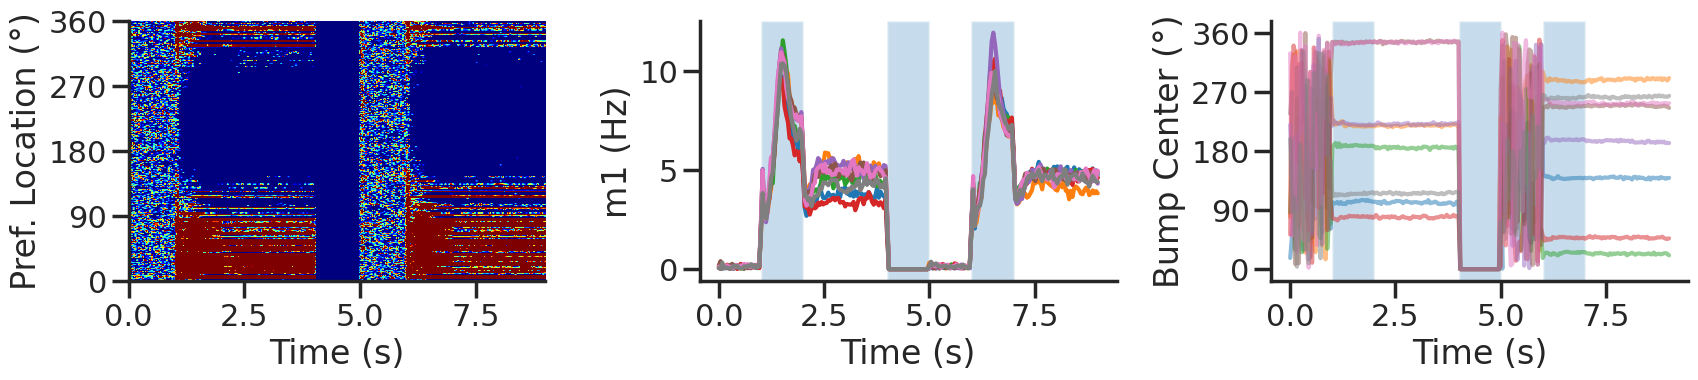

In [1]:
fig, ax = plt.subplots(1, 3, figsize=[2.5*width, height])

idx = np.random.randint(0, model.N_BATCH)
ax[0].imshow(rates[idx].T, aspect='auto', cmap='jet', vmin=0, vmax=2, origin='lower', extent=[0, model.DURATION, 0, model.Na[0].cpu()])
ax[0].set_ylabel('Pref. Location (°)')
ax[0].set_yticks(np.linspace(0, model.Na[0].cpu(), 5), np.linspace(0, 360, 5).astype(int))
ax[0].set_xlabel('Time (s)')

xtime = np.linspace(0, model.DURATION, phi.shape[-1])
idx = np.random.randint(0, model.N_BATCH, 8)
ax[1].plot(xtime, m1[idx].T)
ax[1].set_ylabel('m1 (Hz)')
ax[1].set_xlabel('Time (s)')
add_vlines(model, ax[1])

ax[2].plot(xtime, phi[idx].T * 180 / np.pi, alpha=0.5)
ax[2].set_yticks(np.linspace(0, 360, 5).astype(int), np.linspace(0, 360, 5).astype(int))
ax[2].set_ylabel('Bump Center (°)')
ax[2].set_xlabel('Time (s)')
add_vlines(model, ax[2])
plt.show()

In [1]:
PHI0 = model.PHI0.cpu().detach().numpy() * 180.0 / np.pi
print(PHI0.shape)

idx = np.random.randint(0, 32)
print(PHI0[idx, 0, 0])
window_size = int((model.N_STIM_ON[1]-model.N_STEADY) / model.N_WINDOW)
print(phi[idx, window_size] * 180 / np.pi)

(512, 3, 1)
99.0
98.1910550511595

### Pref loc



In [1]:
model.N_STIM_ON

tensor([150, 300, 400], device='cuda:1')

In [1]:
start_idx = int((model.N_STIM_ON[0] - model.N_STEADY) / model.N_WINDOW)
end_idx = int((model.N_STIM_OFF[0] - model.N_STEADY) / model.N_WINDOW)

mean_rates = rates_tensor[:, start_idx:end_idx].mean(dim=1).cpu().detach().numpy()
angles = model.PHI0[:, 0, 0].cpu().numpy()

In [1]:
import numpy as np

nbins = 16

# Create linearly spaced bin edges from 0 to 360
bins = np.linspace(0, 2*np.pi, nbins + 1)

# Use numpy.histogram to get the bin counts
counts, _ = np.histogram(angles, bins=bins)
print(len(counts))
# Find the bin index for each angle
bin_indices = np.digitize(angles, bins) - 1

16

In [1]:
from astropy.stats.circstats import circmean

In [1]:
pref_locs = []

for i in range(mean_rates.shape[1]):
    normalized_rates = np.zeros_like(mean_rates[:,i], dtype=float)

    for j, rate in enumerate(mean_rates[:, i]):
        bin_index = bin_indices[j]
        if 0 <= bin_index < nbins:  # Ensure index is within valid range
            normalized_rates[j] = rate / counts[bin_index] if counts[bin_index] > 0 else 0

    pref_locs.append(circmean(angles, weights=normalized_rates, axis=0))
pref_locs = np.array(pref_locs)
print(pref_locs.shape)

(750,)

In [1]:
normalized_rates = np.zeros_like(mean_rates, dtype=float)

for i in range(mean_rates.shape[0]):
        bin_index = bin_indices[i]
        if 0 <= bin_index < nbins:  # Ensure index is within valid range
                normalized_rates[i] = mean_rates[i] / counts[bin_index] if counts[bin_index] > 0 else 0

pref_locs = []
for i in range(mean_rates.shape[1]):
        pref_locs.append(circmean(angles, weights=normalized_rates[:, i], axis=0))

pref_locs = (np.array(pref_locs) + 2.0 * np.pi) % (2.0 * np.pi)
print(pref_locs.shape, normalized_rates.shape)

(750,) (512, 750)

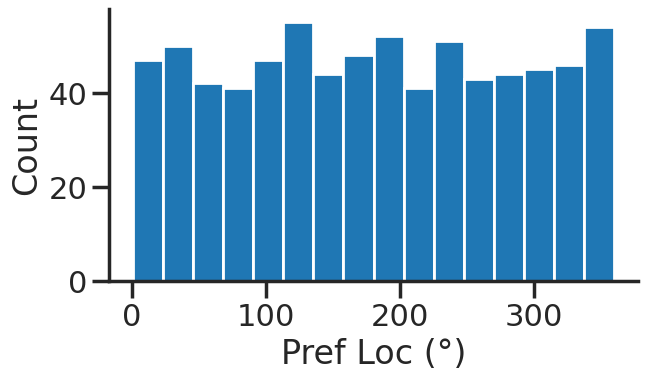

In [1]:
# pref_locs[pref_locs<0] += 2* np.pi
plt.hist(pref_locs * 180 / np.pi, bins=16)
plt.xlabel('Pref Loc (°)')
plt.ylabel('Count')
plt.savefig('figs/christos/selectivity_hist_from_tc.svg', dpi=300)
plt.show()

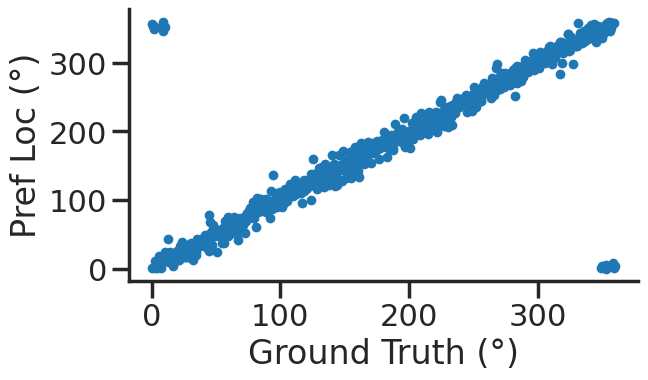

In [1]:
theta = np.linspace(0, 360, pref_locs.shape[-1])
plt.scatter(theta, pref_locs * 180 / np.pi)
plt.xlabel('Ground Truth (°)')
plt.ylabel('Pref Loc (°)')
plt.savefig('figs/christos/selectivity_from_tc.svg', dpi=300)
plt.show()

In [1]:
idx_pref = np.argsort(pref_locs)
m0, m1, phi = decode_bump(rates[..., idx_pref], axis=-1)

### Decoder



In [1]:
start_idx = int((model.N_STIM_OFF[0] + 50 - model.N_STEADY) / model.N_WINDOW)
end_idx = int((model.N_STIM_ON[1] - model.N_STEADY) / model.N_WINDOW)

print(start_idx)
mean_rates = rates_tensor[:, -10:].mean(dim=1).cpu().detach().numpy()
angles = model.PHI0[:, 2, 0].cpu().numpy()

75

In [1]:
from sklearn.neighbors import KernelDensity

def weights_from_pdf(angles_rad, bandwidth=0.5, beta=0.5):
    angles_rad_2d = angles_rad.reshape(-1, 1)
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(angles_rad_2d)
    log_dens = kde.score_samples(angles_rad_2d)
    densities = np.exp(log_dens)

    if beta == 0:
        weights = 1 / (np.exp(log_dens) + 1e-8)
        weights /= weights.mean()
    else:
        # Softmax-normalized inverse density (avoids extreme weights)
        # Temperature parameter: lower beta → more uniform weighting
        weights = np.exp(-beta * densities)
        weights = weights / weights.mean()  # Normalize

    return weights

In [1]:
def weights_from_hist(angles_rad, n_bins=32):
     hist, bin_edges = np.histogram(angles_rad, bins=n_bins)
     bin_indices = np.digitize(angles_rad, bins=bin_edges[:-1], right=True)

     weights = 1.0 / (np.sqrt(hist[bin_indices - 1]) + 1e-6)
     weights /= np.mean(weights)

     return weights

In [1]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, RidgeCV, MultiTaskLassoCV
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.ensemble import BaggingRegressor
from sklearn.preprocessing import StandardScaler
import numpy as np

class AngleDecoder(BaseEstimator, RegressorMixin):
    def __init__(self, penalty=None, scaler=True, class_weight=None):
        self.penalty = penalty
        self.scaler = scaler
        self.class_weight = class_weight
        self.reg_ = None
        self.pipe_ = None
        self._initialize_regressor()

    def _initialize_regressor(self):
        if self.penalty is None:
            self.reg_ = LinearRegression()
        elif self.penalty == 'l2':
            self.reg_ = RidgeCV()
        elif self.penalty == 'l1':
            self.reg_ = MultiTaskLassoCV()
        elif self.penalty == 'multi':
            self.reg_ = MultiOutputRegressor(LinearSVR())
        elif self.penalty == 'rbf':
            self.reg_ = MultiOutputRegressor(SVR(kernel='rbf', C=1e3, gamma=0.1))

        pipe = []
        if self.scaler:
            pipe.append(('scaler', StandardScaler()))

        pipe.append(('reg', self.reg_))

        self.pipe_ = Pipeline(pipe)

    def fit(self, X, y):
        Y = np.column_stack((np.cos(y), np.sin(y)))

        weights = None
        if class_weight=='balanced' or class_weight:
            # weights = weights_from_hist(angles, n_bins=32)
            weights = weights_from_pdf(y, bandwidth=1.0, beta=0.1)

        self.pipe_.fit(X, Y, reg__sample_weight=weights)

        if self.penalty == 'rbf':
            pref_locs = np.nan
        else:
            pred_cos = self.pipe_.named_steps['reg'].coef_[0]
            pred_sin = self.pipe_.named_steps['reg'].coef_[1]
            pref_locs = np.arctan2(pred_sin, pred_cos)

        self.pref_locs_ = (pref_locs + 2.0 * np.pi) % (2.0 * np.pi)

        return self

    def predict(self, X):
        preds = self.pipe_.predict(X)
        pred_cos, pred_sin = preds[:, 0], preds[:, 1]
        pred_loc = np.arctan2(pred_sin, pred_cos)
        return (pred_loc + 2.0 * np.pi) % (2.0 * np.pi)

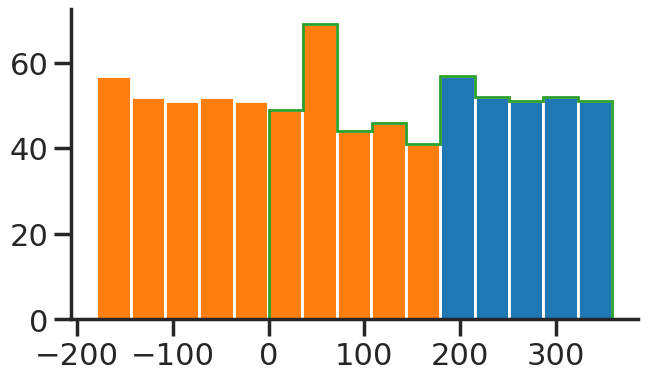

In [1]:
plt.hist(angles * 180 / np.pi)
theta = (angles - np.pi) % (2*np.pi) - np.pi
plt.hist(theta * 180 / np.pi);
theta2 = (theta + 2*np.pi) % (2*np.pi)
plt.hist(theta2 * 180 / np.pi, histtype='step')
plt.show()

In [1]:
regressor = AngleDecoder(penalty=None, scaler=True, class_weight='balanced')
regressor.fit(mean_rates, angles);

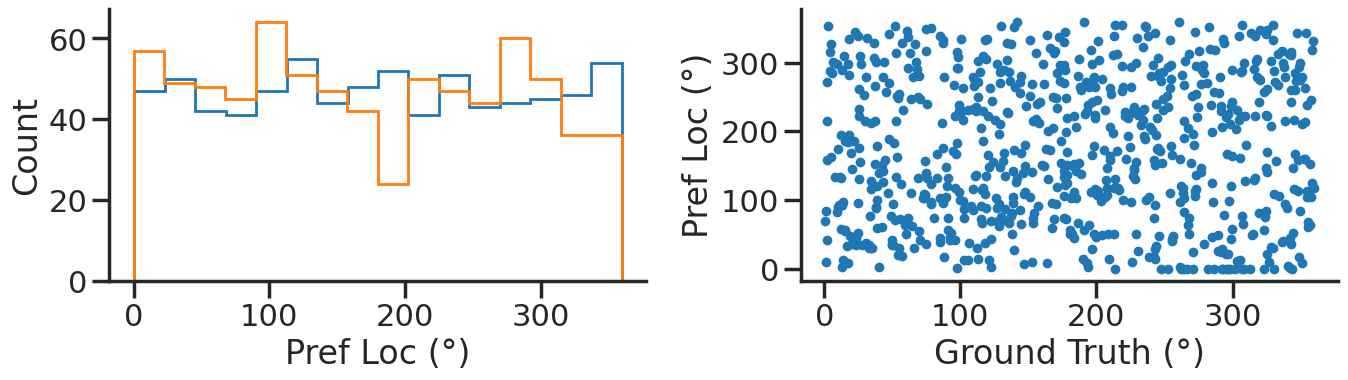

In [1]:
fig, ax = plt.subplots(1, 2, figsize=[2*width, height])
ax[0].hist(pref_locs * 180 / np.pi, histtype='step', bins=16)
ax[0].hist(regressor.pref_locs_ * 180 / np.pi, histtype='step', bins=16)
ax[0].set_ylabel('Count')
ax[0].set_xlabel('Pref Loc (°)')

ax[1].scatter(pref_locs * 180 / np.pi, regressor.pref_locs_ * 180 / np.pi)
ax[1].set_xlabel('Ground Truth (°)')
ax[1].set_ylabel('Pref Loc (°)')

plt.savefig('figs/christos/selectivity_from_dec.svg', dpi=300)
plt.show()

In [1]:
from sklearn.model_selection import cross_val_predict, LeaveOneOut
pred_locs = cross_val_predict(regressor, mean_rates, angles, cv=LeaveOneOut(), n_jobs=-1)

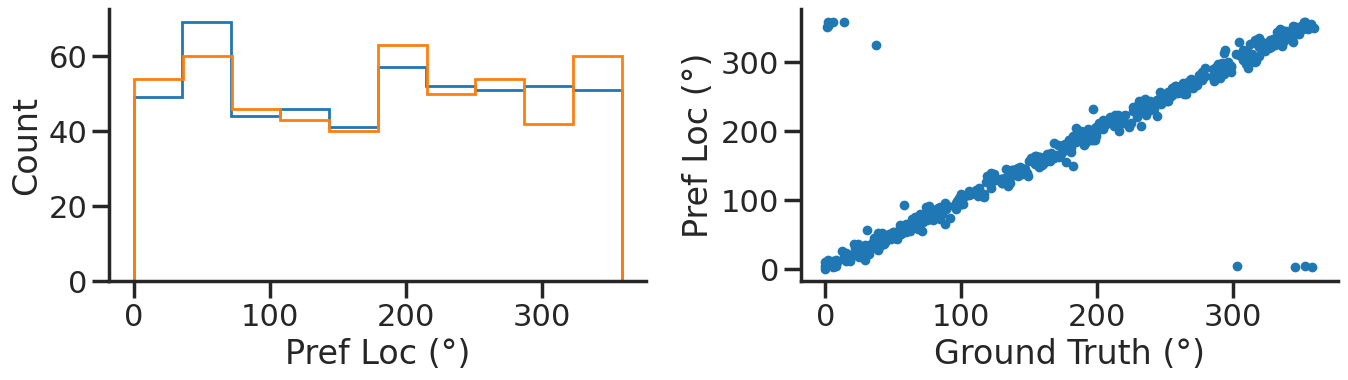

In [1]:
fig, ax = plt.subplots(1, 2, figsize=[2*width, height])
ax[0].hist(angles * 180 / np.pi, histtype='step')
ax[0].hist(pred_locs * 180 / np.pi, histtype='step')
ax[0].set_ylabel('Count')
ax[0].set_xlabel('Pref Loc (°)')

ax[1].scatter(angles * 180 / np.pi, pred_locs * 180 / np.pi)
ax[1].set_xlabel('Ground Truth (°)')
ax[1].set_ylabel('Pref Loc (°)')

plt.savefig('figs/christos/selectivity_from_dec.svg', dpi=300)
plt.show()

In [1]:
print(pred_locs.shape)

(512,)

In [1]:
from mne.decoding import SlidingEstimator
mne_estimator = SlidingEstimator(regressor, n_jobs=1, verbose=False)
# pred_locs = cross_val_predict(mne_estimator, rates.swapaxes(1,2), angles, cv=LeaveOneOut(), n_jobs=-1)

In [1]:
import numpy as np
from sklearn.metrics import make_scorer

def mean_angular_error(y_true, y_pred):
    # Ensure angles are between 0 and 2*pi
    angular_diff = np.angle(np.exp(1j * (y_true - y_pred)))
    return np.mean(np.abs(angular_diff))

# Create a scikit-learn scorer
angular_error_scorer = make_scorer(mean_angular_error, greater_is_better=False)

In [1]:
from mne.decoding import SlidingEstimator, cross_val_multiscore
# mne_estimator = SlidingEstimator(regressor, n_jobs=None, scoring=angular_error_scorer, verbose=False)
# scores = cross_val_multiscore(mne_estimator, rates.swapaxes(1,2), angles, cv=5, n_jobs=None)

In [1]:
# plt.plot(scores.mean(0));

In [1]:
# idx = np.argsort(regressor.pref_locs_)
# mean_rates = mean_rates[:, idx]
# m0, m1, phi = decode_bump(rates[..., idx], axis=-1)

### errors



In [1]:
# phi = pred_locs[:, np.newaxis]
target_loc = PHI0[:, -1]

rel_loc = (PHI0[:, 0] - target_loc) * np.pi / 180.0
rel_loc = (rel_loc + np.pi) % (2 * np.pi) - np.pi
rel_loc *= 180 / np.pi

ref_loc = (reference - PHI0[:, -1]) * np.pi / 180.0
ref_loc = (ref_loc + np.pi) % (2 * np.pi) - np.pi
ref_loc *= 180 / np.pi

rel_loc = (PHI0[:, 0] - target_loc) * np.pi / 180.0
rel_loc = (rel_loc + np.pi) % (2 * np.pi) - np.pi
rel_loc *= 180 / np.pi

anti_ref_loc = (180.0 - reference - PHI0[:, -1]) * np.pi / 180.0
anti_ref_loc = (anti_ref_loc + np.pi) % (2 * np.pi) - np.pi
anti_ref_loc *= 180 / np.pi

window_size = int((model.N_STIM_OFF[-1]-model.N_STEADY) / model.N_WINDOW)
# errors = phi - phi[:, window_size][:, np.newaxis]
errors = (phi - target_loc * np.pi / 180.0)
errors = (errors + np.pi) % (2 * np.pi) - np.pi
errors *= 180 / np.pi

window_size = int((model.N_STIM_OFF[0]-model.N_STEADY) / model.N_WINDOW)
errors2 = ((phi - PHI0[:, 0] * np.pi / 180.0))
# errors2 = phi - phi[:, window_size][:, np.newaxis]
errors2 = (errors2 + np.pi) % (2 * np.pi) - np.pi
errors2 *= 180 / np.pi

print(errors.shape, target_loc.shape, rel_loc.shape, ref_loc.shape)

(512, 226) (512, 1) (512, 1) (512, 1)

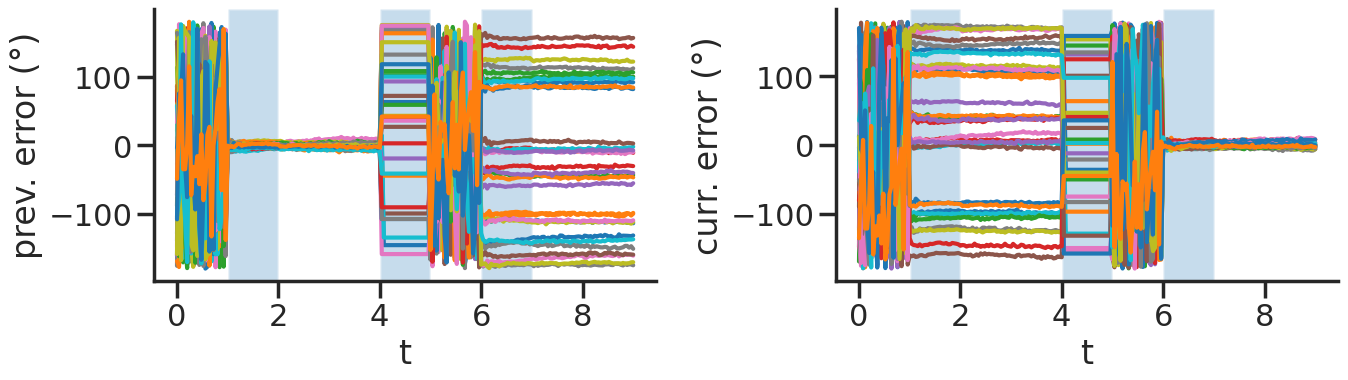

In [1]:
fig, ax = plt.subplots(1, 2, figsize=[2*width, height])
ax[0].plot(np.linspace(0, model.DURATION, errors.shape[-1]), errors2[:32].T)
add_vlines(model, ax[0])
# ax[0].set_xlim([2.5, 4.5])
ax[0].set_xlabel('t')
ax[0].set_ylabel('prev. error (°)')

ax[1].plot(np.linspace(0, model.DURATION, errors.shape[-1]), errors[:32].T)
add_vlines(model, ax[1])
ax[1].set_xlabel('t')
ax[1].set_ylabel('curr. error (°)')
plt.show()

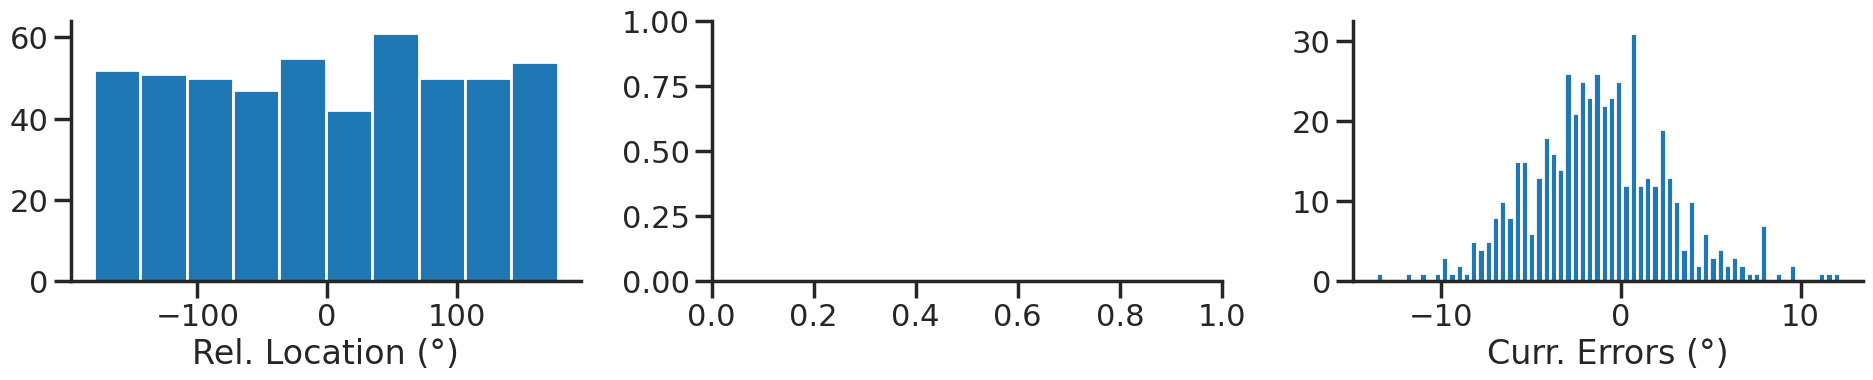

In [1]:
fig, ax = plt.subplots(1, 3, figsize=[2.75*width, height])
ax[0].hist(rel_loc[:, 0], bins='auto')
ax[0].set_xlabel('Rel. Location (°)')

# ax[1].hist(errors2[:, int((model.N_STIM_ON[1]-model.N_STEADY)/model.N_WINDOW)], bins='auto')
# ax[1].set_xlabel('Prev. Errors (°)')

ax[2].hist(errors[:, -1], bins=64)
ax[2].set_xlabel('Curr. Errors (°)')
# ax[1].set_xlim([-45, 45])
plt.show()

In [1]:
mask = np.abs(errors) <= 25
print(mask.shape)

errors = np.where(mask, errors, np.nan)[:, -1]
print(errors.shape)
rel_loc = rel_loc[~np.isnan(errors)]
ref_loc = ref_loc[~np.isnan(errors)]
anti_ref_loc = anti_ref_loc[~np.isnan(errors)]
target_loc = target_loc[:, -1][~np.isnan(errors), np.newaxis]
errors = errors[~np.isnan(errors), np.newaxis]
# errors = errors[mask]
print(errors.shape, target_loc.shape, rel_loc.shape, ref_loc.shape)

(512, 226)
(512,)
(512, 1) (512, 1) (512, 1) (512, 1)


# [goto error]
---------------------------------------------------------------------------
IndexError                                Traceback (most recent call last)
Cell In[106], line 5
      2 ax[0].hist(rel_loc[:, 0], bins='auto')
      3 ax[0].set_xlabel('Rel. Location (°)')
----> 5 ax[1].hist(errors2[:, int((model.N_STIM_ON[1]-model.N_STEADY)/model.N_WINDOW)], bins='auto')
      6 ax[1].set_xlabel('Prev. Errors (°)')
      8 ax[2].hist(errors[:, -1], bins='auto')
:
IndexError: index 100 is out of bounds for axis 1 with size 1



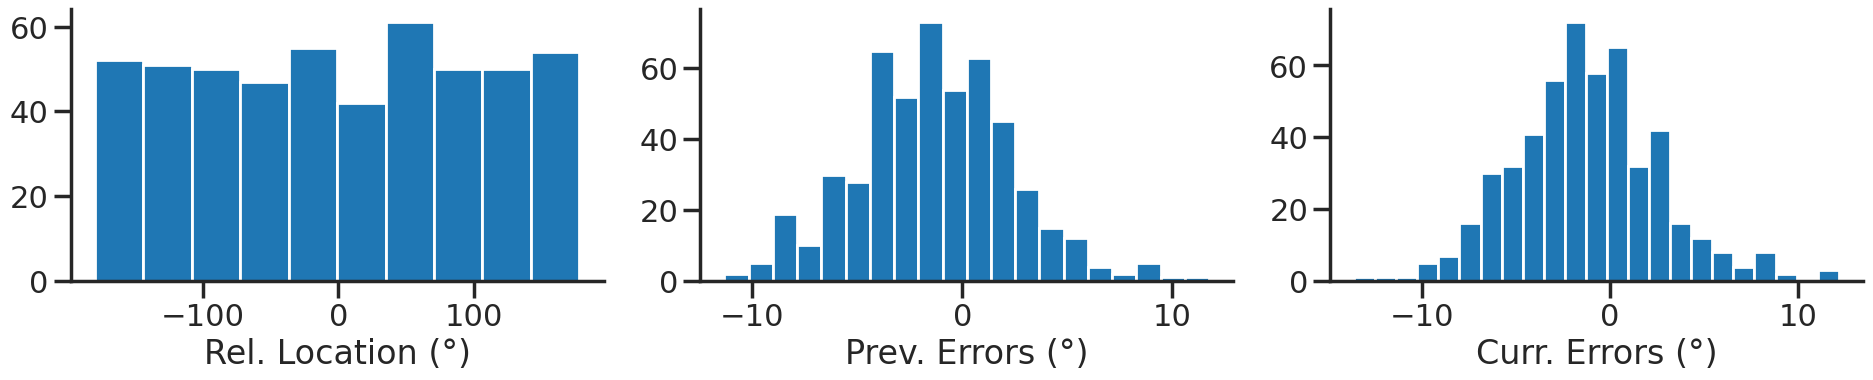

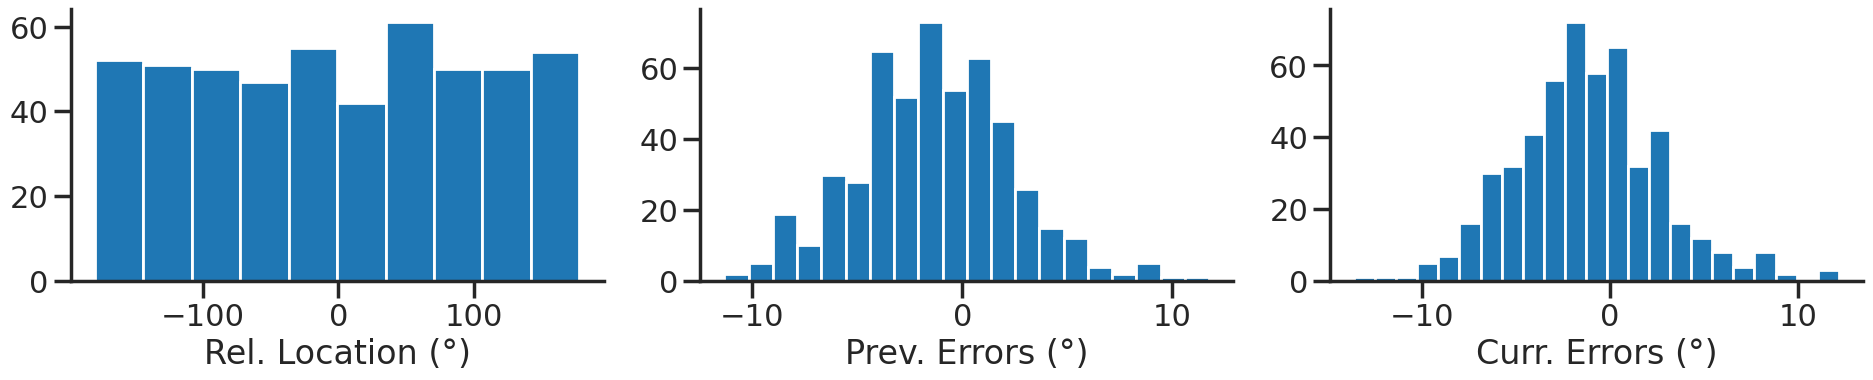

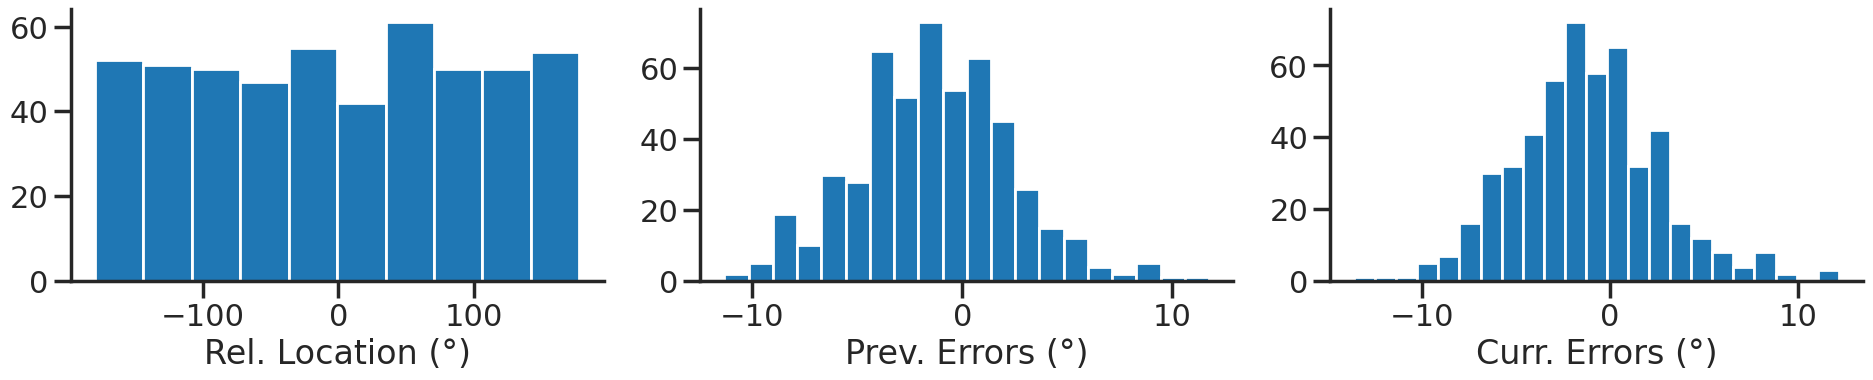

In [1]:
fig, ax = plt.subplots(1, 3, figsize=[2.75*width, height])
ax[0].hist(rel_loc[:, 0], bins='auto')
ax[0].set_xlabel('Rel. Location (°)')

ax[1].hist(errors2[:, int((model.N_STIM_ON[1]-model.N_STEADY)/model.N_WINDOW)], bins='auto')
ax[1].set_xlabel('Prev. Errors (°)')

ax[2].hist(errors[:, -1], bins='auto')
ax[2].set_xlabel('Curr. Errors (°)')
# ax[1].set_xlim([-45, 45])
plt.show()

### biases



In [1]:
data = pd.DataFrame({'target_loc': target_loc[:, -1], 'rel_loc': rel_loc[:, -1], 'errors': errors[:, -1], 'ref_loc': ref_loc[:, -1]})

if IF_BIAS:
    df_naive = pkl_load('df_naive_%d' % seed, path="./figures/odr")
else:
    df_naive = data

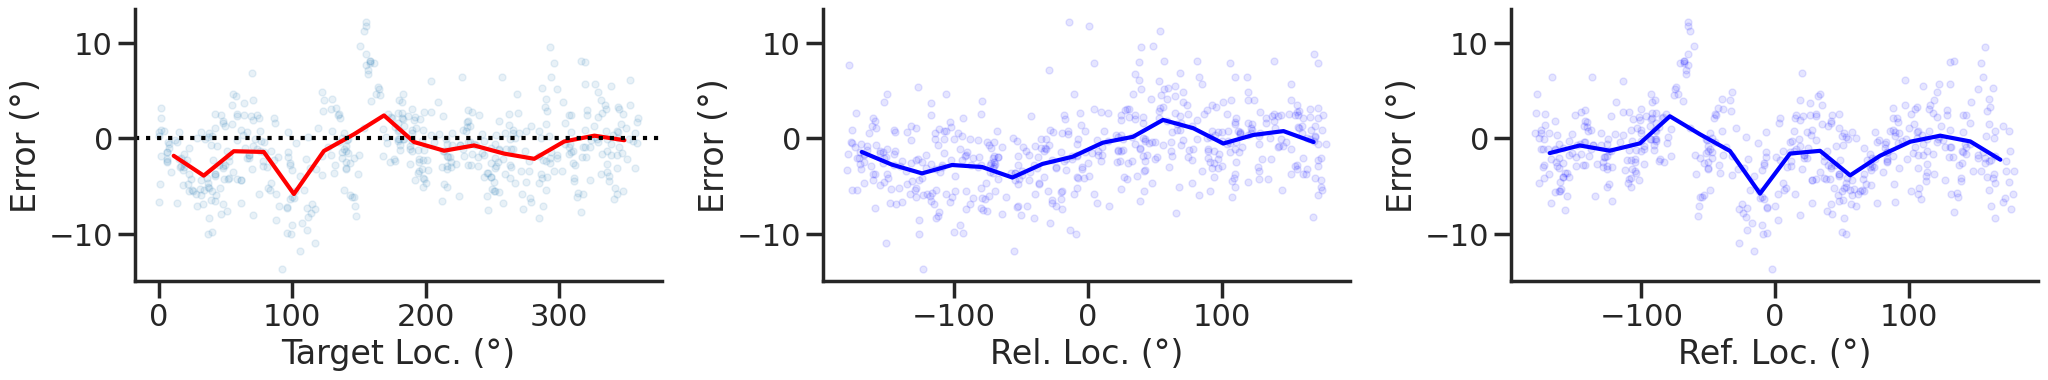

In [1]:
fig, ax = plt.subplots(1, 3, figsize=[3*width, height])

n_bins=16
ax[0].plot(df_naive['target_loc'], df_naive['errors'], 'o', alpha=.1)
ax[0].set_xlabel('Target Loc. (°)')
ax[0].set_ylabel('Error (°)')

stt = binned_statistic(df_naive['target_loc'], df_naive['errors'], statistic='mean', bins=n_bins, range=[0, 360])
dstt = np.mean(np.diff(stt.bin_edges))
ax[0].plot(stt.bin_edges[:-1]+dstt/2,stt.statistic,'r')

ax[0].axhline(color='k', linestyle=":")

ax[1].plot(rel_loc[:, 0], errors[:,-1], 'bo', alpha=.1)
ax[1].set_xlabel('Rel. Loc. (°)')
ax[1].set_ylabel('Error (°)')

stt = binned_statistic(rel_loc[:, 0], errors[:, -1], statistic='mean', bins=n_bins, range=[-180, 180])
dstt = np.mean(np.diff(stt.bin_edges))
ax[1].plot(stt.bin_edges[:-1]+dstt/2, stt.statistic, 'b')

ax[2].plot(ref_loc[:, 0], errors[:,-1], 'bo', alpha=.1)
ax[2].set_xlabel('Ref. Loc. (°)')
ax[2].set_ylabel('Error (°)')

stt = binned_statistic(ref_loc[:, 0], errors[:, -1], statistic='mean', bins=n_bins, range=[-180, 180])
dstt = np.mean(np.diff(stt.bin_edges))
ax[2].plot(stt.bin_edges[:-1]+dstt/2, stt.statistic, 'b')

plt.savefig('./figs/christos/uncorr_biases.svg', dpi=300)
plt.show()

In [1]:
n_bins = 16
angle_min = 0
angle_max = 360

bin_edges = np.linspace(angle_min, angle_max, n_bins + 1)
data['bin_target'] = pd.cut(data['target_loc'], bins=bin_edges, include_lowest=True)

mean_errors_per_bin = data.groupby('bin_target')['errors'].mean()
data['adjusted_errors'] = data.apply(
    lambda row: row['errors'] - mean_errors_per_bin.loc[row['bin_target']],
    axis=1
)

if IF_BIAS:
   df_naive['bin_target'] = pd.cut(df_naive['target_loc'], bins=bin_edges, include_lowest=True)
   mean_errors_per_bin = df_naive.groupby('bin_target')['errors'].mean()

   data['errors_naive'] = data.apply(
      lambda row: row['errors'] - mean_errors_per_bin.loc[row['bin_target']],
      axis=1
   )


bin_target = data.groupby('bin_target')['adjusted_errors'].agg(['mean', 'sem']).reset_index()
edges = bin_target['bin_target'].cat.categories
target_centers = (edges.left + edges.right) / 2

data['bin_rel'] = pd.cut(data['rel_loc'], bins=n_bins)
bin_rel = data.groupby('bin_rel')['adjusted_errors'].agg(['mean', 'sem']).reset_index()

edges = bin_rel['bin_rel'].cat.categories
centers = (edges.left + edges.right) / 2

data['bin_ref'] = pd.cut(data['ref_loc'], bins=n_bins)

if IF_BIAS:
   bin_ref = data.groupby('bin_ref')['errors_naive'].agg(['mean', 'sem']).reset_index()
else:
   bin_ref = data.groupby('bin_ref')['adjusted_errors'].agg(['mean', 'sem']).reset_index()

ref_edges = bin_ref['bin_ref'].cat.categories
ref_centers = (ref_edges.left + ref_edges.right) / 2

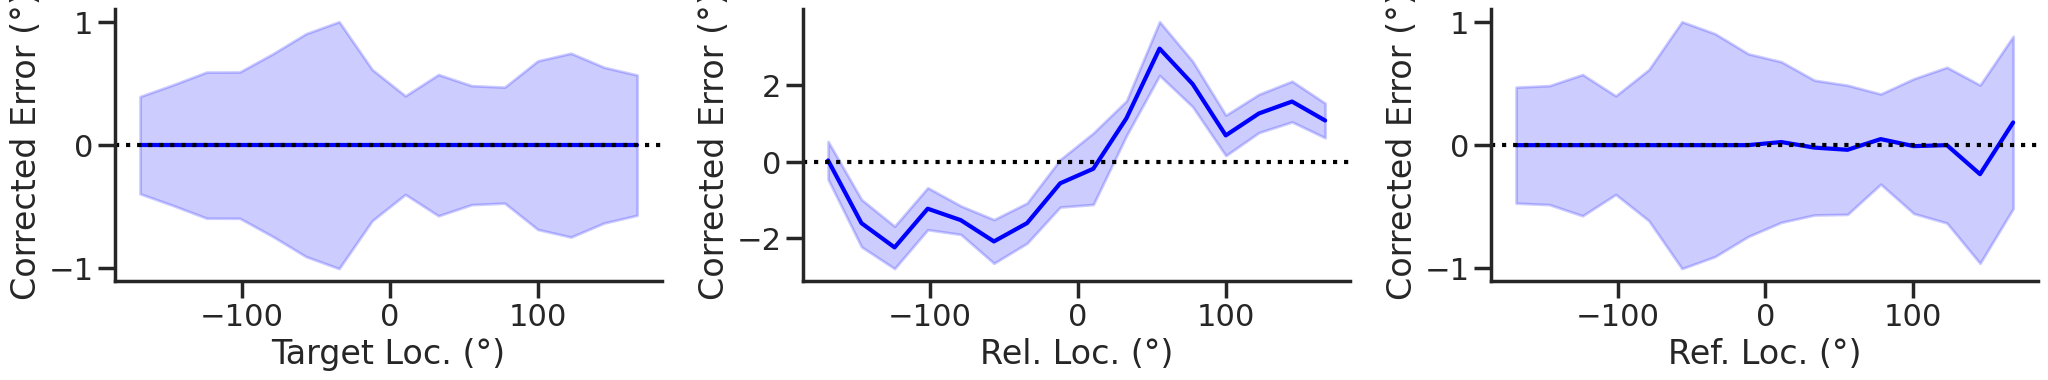

In [1]:
fig, ax = plt.subplots(1, 3, figsize=[3*width, height])
ax[0].plot(centers, bin_target['mean'], 'b')
ax[0].fill_between(centers,
                   bin_target['mean'] - bin_target['sem'],
                   bin_target['mean'] + bin_target['sem'],
                   color='b', alpha=0.2)

ax[0].axhline(color='k', linestyle=":")
ax[0].set_xlabel('Target Loc. (°)')
ax[0].set_ylabel('Corrected Error (°)')

ax[1].plot(centers, bin_rel['mean'], 'b')
ax[1].fill_between(centers,
                bin_rel['mean'] - bin_rel['sem'],
                bin_rel['mean'] + bin_rel['sem'],
                color='b', alpha=0.2)

ax[1].axhline(color='k', linestyle=":")
ax[1].set_xlabel('Rel. Loc. (°)')
ax[1].set_ylabel('Corrected Error (°)')

ax[2].plot(ref_centers, bin_ref['mean'], 'b')
ax[2].fill_between(ref_centers,
                bin_ref['mean'] - bin_ref['sem'],
                bin_ref['mean'] + bin_ref['sem'],
                color='b', alpha=0.2)

ax[2].axhline(color='k', linestyle=":")
ax[2].set_xlabel('Ref. Loc. (°)')
ax[2].set_ylabel('Corrected Error (°)')

if IF_BIAS:
    plt.savefig('./figures/odr/odr_biases_train.svg', dpi=300)
else:
    plt.savefig('./figures/odr/odr_biases_naive.svg', dpi=300)

plt.savefig('./figs/christos/corr_biases.svg', dpi=300)
plt.show()

In [1]:
if IF_BIAS==0:
   pkl_save(data, 'df_naive_%d' %seed, path="./figures/odr")

saving to ./figures/odr/df_naive_1.pkl

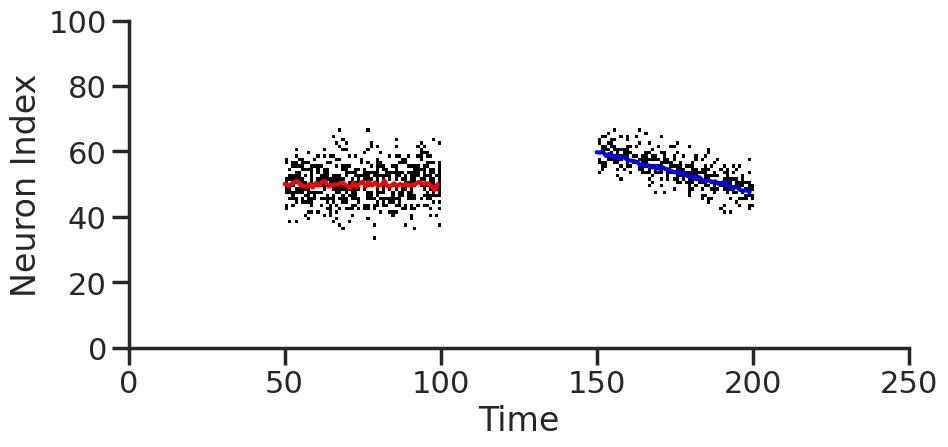

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
n_neurons = 100  # Number of neurons
n_time_points = 250  # Number of time points
first_bump_start = 50
first_bump_end = 100
second_bump_start = 150
second_bump_end = 200

# Setup activity matrix
activity = np.zeros((n_neurons, n_time_points))

# Centers of the bumps
centers = np.zeros(n_time_points)

# Generate a diffused first bump
for t in range(first_bump_start, first_bump_end):
    center = n_neurons // 2 # + (t - first_bump_start)  # diffusing to the right
    deviation = 5
    spread = np.random.normal(loc=center, scale=deviation, size=n_neurons)
    activity[:, t] = np.exp(-np.square(np.arange(n_neurons) - spread) / (2 * deviation**2))
    centers[t] = spread.mean()

# Retrieve the end center of the first bump
first_bump_end_center = centers[first_bump_end - 1]

# Generate a second bump that moves towards the first bump's end
for t in range(second_bump_start, second_bump_end):
    center = 10 + first_bump_end_center - (t - second_bump_start) / 4  # moving left towards first bump's end
    deviation = 3
    spread = np.random.normal(loc=center, scale=deviation, size=n_neurons)
    activity[:, t] = np.exp(-np.square(np.arange(n_neurons) - spread) / (2 * deviation**2))
    centers[t] = spread.mean()

# Normalize activity for binary visualization
activity = activity > 0.6

# Plot
plt.figure(figsize=(10, 5))
plt.imshow(activity, aspect='auto', cmap='binary', extent=[0, n_time_points, 0, n_neurons], origin='lower')
plt.plot(range(first_bump_start, first_bump_end), centers[first_bump_start:first_bump_end], color='red', label='Center of 1st Bump')
plt.plot(range(second_bump_start, second_bump_end), centers[second_bump_start:second_bump_end], color='blue', label='Center of 2nd Bump')
plt.xlabel('Time')
plt.ylabel('Neuron Index')
# plt.title('Raster Plot with Two Bumps of Activity and Centers')
# plt.colorbar(label='Activity')
# plt.legend()
plt.show()

### Landscape



In [1]:
sys.path.insert(0, '/home/leon/dual_task/dual_data/')
from src.attractor.landscape import EnergyLandscape

In [1]:
energy = EnergyLandscape()
print(phi.shape)

(512, 226)

In [1]:
num_bins = 96
bins = np.linspace(0, 2 * np.pi, num_bins, endpoint=False)
landscape = energy.fit(phi, bins)
landscape[0] = landscape[-1]
print(landscape.shape)

(96,)

In [1]:
if IF_BIAS:
        pkl_save(landscape, 'landscape_bias', path="/home/leon/")
        landscape_ = pkl_load('landscape', path="/home/leon/")
else:
        pkl_save(landscape, 'landscape', path="/home/leon/")

saving to /home/leon//landscape.pkl

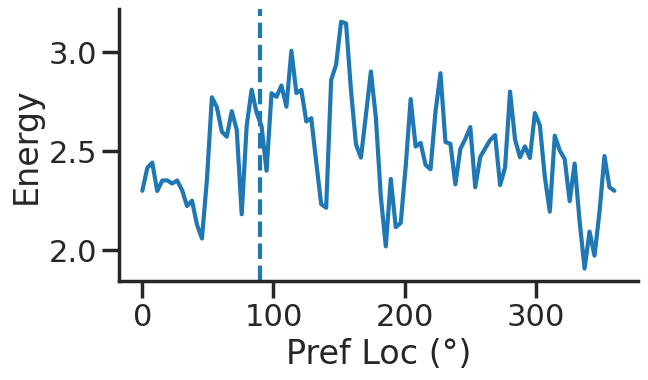

In [1]:
plt.plot(np.linspace(0, 360, landscape.shape[0]), landscape)
if IF_BIAS:
    landscape_[0] = landscape_[-1]
    plt.plot(np.linspace(0, 360, landscape.shape[0]), landscape_)

plt.axvline(reference, 0, 1, ls='--')
plt.xlabel('Pref Loc (°)')
plt.ylabel('Energy')
plt.show()

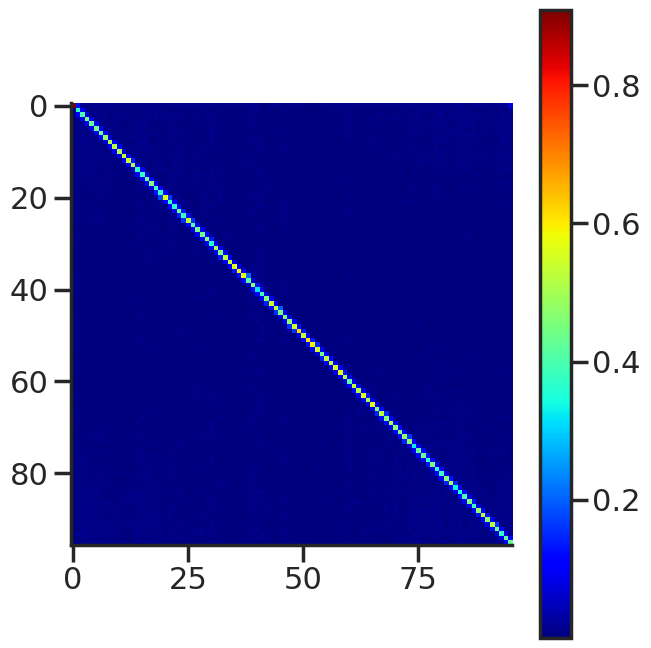

In [1]:
plt.figure(figsize=(7, 7))
plt.imshow(energy.transition_matrix.T, cmap='jet')
plt.colorbar()
plt.show()

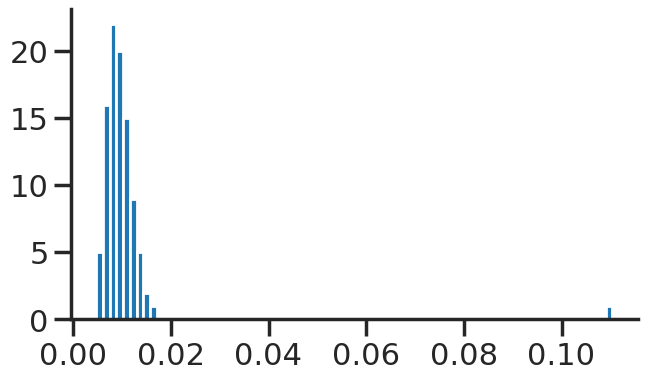

In [1]:
plt.hist(energy.steady_state, bins='auto')
plt.show()

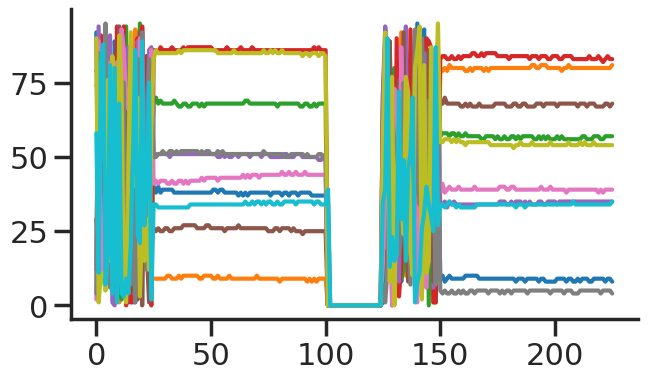

In [1]:
X_discrete = np.digitize(phi,  bins, right=False)-1
plt.plot(X_discrete.T[:,:10])
plt.show()

In [1]:
np.mean(X_discrete==1)

0.009852046460176992

### Tuning



In [1]:
mean_rates = rates_tensor[:, start_idx:end_idx, idx_pref].mean(dim=1)
angles = model.PHI0[:, 0, 0]

In [1]:
import torch

def calculate_osi_and_circular_variance(rates, angles):

    # Step 2: Compute the preferred angle and responses
    unique_angles = torch.unique(angles)
    angle_responses = torch.stack([mean_rates[angles == angle].mean(dim=0) for angle in unique_angles])

    R_pref, pref_indices = angle_responses.max(dim=0)
    pref_angles = unique_angles[pref_indices]

    # Step 3: Calculate the orthogonal angle
    orth_angles = (pref_angles + torch.pi / 2) % (2 * torch.pi)

    # Find closest angles in unique_angles for each orth_angle
    orth_indices = torch.argmin(torch.abs(unique_angles.unsqueeze(1) - orth_angles), dim=0)
    R_orth = angle_responses.gather(0, orth_indices.unsqueeze(0)).squeeze(0)

    # Calculate OSI
    osi = (R_pref - R_orth) / (R_pref + R_orth).clamp(min=1e-6)

    # Step 4: Calculate Circular Variance
    complex_sum = torch.sum(angle_responses * torch.exp(1j * unique_angles.unsqueeze(1)), dim=0)
    cv = 1 - torch.abs(complex_sum) / angle_responses.sum(dim=0).clamp(min=1e-6)

    return osi, cv, pref_angles

osi, circvar, pref = calculate_osi_and_circular_variance(torch.tensor(mean_rates), torch.tensor(angles))

In [1]:
if IF_BIAS:
        pkl_save(osi, 'osi_bias', path="/home/leon/")
        pkl_save(circvar, 'circvar_bias', path="/home/leon/")
        pkl_save(pref, 'pref_bias', path="/home/leon/")

        osi_ = pkl_load('osi', path="/home/leon/")
        circvar_ = pkl_load('circvar', path="/home/leon/")
        pref_ = pkl_load('pref', path="/home/leon/")
else:
        pkl_save(osi, 'osi', path="/home/leon/")
        pkl_save(circvar, 'circvar', path="/home/leon/")
        pkl_save(pref, 'pref', path="/home/leon/")

saving to /home/leon//osi.pkl
saving to /home/leon//circvar.pkl
saving to /home/leon//pref.pkl

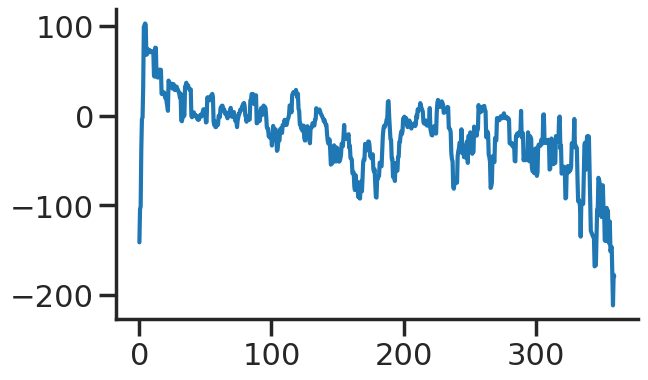

In [1]:
theta = torch.linspace(
    0,
    2.0 * torch.pi,
    pref.shape[-1] + 1,
    device=DEVICE,
)[:-1]

plt.plot(theta.cpu().numpy() * 180 / np.pi, circcvl(pref.cpu().numpy()- theta.cpu().numpy()) * 180 / np.pi)
if IF_BIAS:
    plt.plot(theta.cpu().numpy() * 180 / np.pi, circcvl(pref_.cpu().numpy()- theta.cpu().numpy()) * 180 / np.pi)
plt.show()

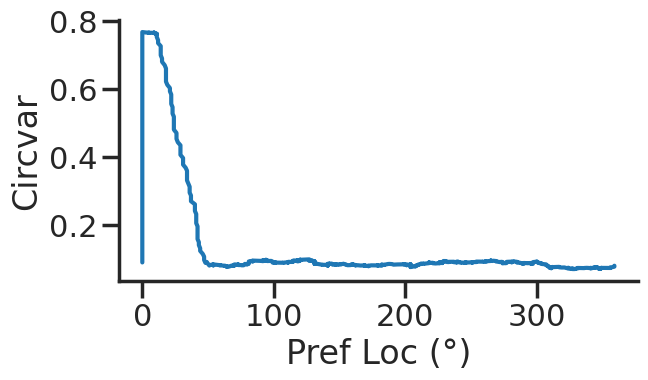

In [1]:
pref, indices = torch.sort(pref, descending=False)
plt.plot(pref.cpu().detach() * 180 / np.pi, circcvl(circvar[indices].cpu().detach(), windowSize=100))

if IF_BIAS:
    pref_, indices_ = torch.sort(pref_, descending=False)
    plt.plot(pref_.cpu().detach()* 180 / np.pi, circcvl(circvar_[indices_].cpu().detach(), windowSize=100))

plt.xlabel('Pref Loc (°)')
plt.ylabel('Circvar')
plt.show()

In [1]:
if IF_BIAS:
    plt.plot(pref.cpu().numpy()-pref_.cpu().numpy())
    plt.show()

In [1]:
if IF_BIAS:
    plt.scatter(pref_.cpu().numpy(), pref.cpu().numpy())
    plt.show()

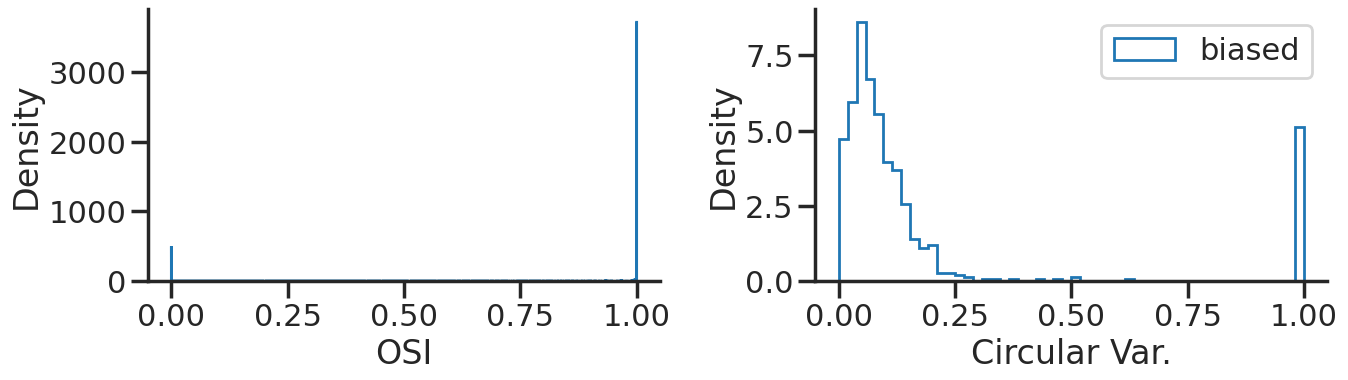

In [1]:
fig, ax = plt.subplots(1, 2, figsize=[2*width, height])

ax[0].hist(osi.cpu().detach(), bins='auto', density=True, histtype='step')
ax[0].set_xlabel('OSI')
ax[0].set_ylabel('Density')

ax[1].hist(circvar.cpu().detach(), bins='auto', density=True, histtype='step', label='biased')
ax[1].set_xlabel('Circular Var.')
ax[1].set_ylabel('Density')

if IF_BIAS:
    ax[0].hist(osi_.cpu().detach(), bins='auto', density=True, histtype='step')
    ax[1].hist(circvar_.cpu().detach(), bins='auto', density=True, histtype='step', label='unbiased')

plt.legend()
plt.savefig('figs/christos/osi_circvar.svg', dpi=300)
plt.show()

In [1]:
if IF_BIAS:
    fig, ax = plt.subplots(1, 2, figsize=[2*height, height])

    ax[0].scatter(osi_.cpu().detach(), osi.cpu().detach())
    ax[0].set_xlabel('Unbiased OSI')
    ax[0].set_ylabel('Biased OSI')

    ax[1].scatter(circvar_.cpu().detach(), circvar.cpu().detach())
    ax[1].set_xlabel('Unbiased circvar')
    ax[1].set_ylabel('Biased circvar')

    plt.savefig('figs/christos/osi_circvar_scatter.svg', dpi=300)
    plt.show()

In [1]:
def plot_neuron_tuning_curves(mean_rates, angles, neuron_indices, device='cpu'):
    # Normalize angles to [-pi, pi)
    angles = (angles ) % (2 * torch.pi) - torch.pi
    angles, indices = torch.sort(angles, descending=False)

    # Reorder the mean_rates tensor using the sorted indices
    mean_rates = mean_rates[indices]

    # Get unique angles and their inverse indices
    unique_angles, inverse_indices = torch.unique(angles, return_inverse=True)
    n_neurons = mean_rates.size(1)

    # Calculate responses per angle
    summed_responses = torch.zeros(len(unique_angles), n_neurons, device=device)
    for i, angle_idx in enumerate(inverse_indices):
        summed_responses[angle_idx] += mean_rates[i]

    # Average the responses
    angle_counts = torch.bincount(inverse_indices, minlength=len(unique_angles))
    averaged_responses = summed_responses / angle_counts.unsqueeze(1).float()

    print(unique_angles[:10])
    # Align responses to each neuron's preferred location
    aligned_responses = torch.empty_like(averaged_responses)

    for neuron_idx in range(n_neurons):
        responses = averaged_responses[:, neuron_idx]
        preferred_idx = responses.argmax()
        aligned_responses[:, neuron_idx] = torch.roll(responses, shifts=-preferred_idx.item(), dims=0)

    mean_aligned_responses = aligned_responses

    # Adjust unique angle values for consistent plotting
    unique_angles[unique_angles < 0] += 2 * torch.pi
    mean_aligned_responses[0] = mean_aligned_responses[-1]

    unique_angles, indices = torch.sort(unique_angles, descending=False)
    mean_aligned_responses = mean_aligned_responses[indices]

    return unique_angles, mean_aligned_responses

neuron_indices = np.arange(0, 10)  # example indices, not needed for average
aligned_angles, population_tuning_curve  = plot_neuron_tuning_curves(mean_rates, angles, neuron_indices, device='cuda:1')

tensor([-3.1416, -3.1067, -3.0892, -3.0718, -3.0543, -3.0369, -2.9845, -2.9671,
        -2.9496, -2.9322], device='cuda:1')

| <matplotlib.lines.Line2D | at | 0x7ff11867b790> |


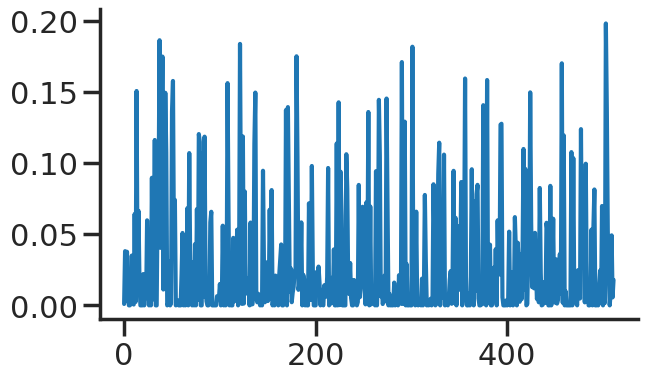

In [1]:
plt.plot(normalized_rates[:, 5])

In [1]:
if IF_BIAS:
        pkl_save(aligned_angles, 'aligned_angles_bias', path="/home/leon/")
        pkl_save(population_tuning_curve, 'population_tuning_curve_bias', path="/home/leon/")

        aligned_angles_ = pkl_load('aligned_angles', path="/home/leon/")
        population_tuning_curve_ = pkl_load('population_tuning_curve', path="/home/leon/")
else:
        pkl_save(aligned_angles, 'aligned_angles', path="/home/leon/")
        pkl_save(population_tuning_curve, 'population_tuning_curve', path="/home/leon/")

saving to /home/leon//aligned_angles.pkl
saving to /home/leon//population_tuning_curve.pkl

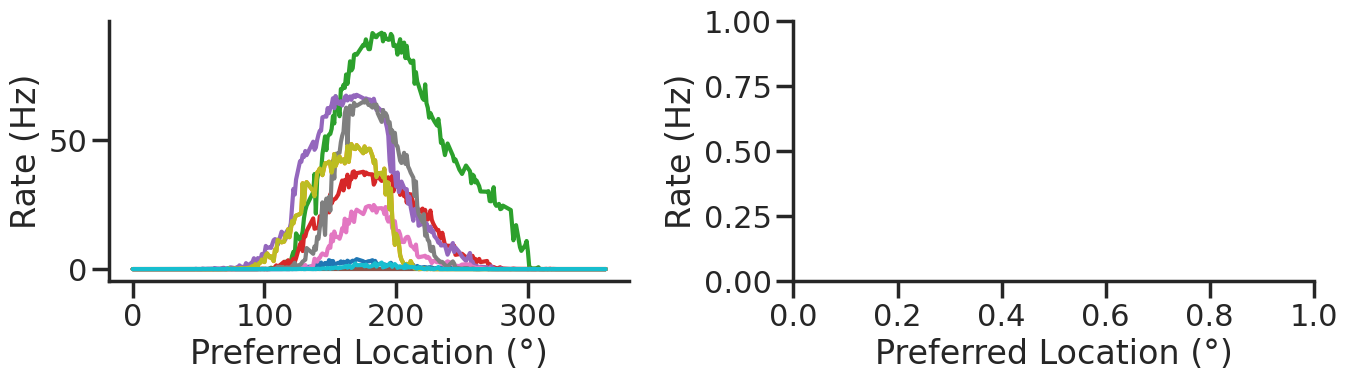

In [1]:
fig, ax = plt.subplots(1, 2, figsize=[2*width, height])
for i in range(10):
    i = np.random.randint(750)
    ax[0].plot(aligned_angles.cpu().numpy() * 180 / np.pi, population_tuning_curve[:, i].cpu().detach().numpy(), '-')
    if IF_BIAS:
        ax[1].plot(aligned_angles_.cpu().numpy() * 180 / np.pi, population_tuning_curve_[:, i].cpu().detach().numpy(), '-')

ax[0].set_xlabel('Preferred Location (°)')
ax[0].set_ylabel('Rate (Hz)')

ax[1].set_xlabel('Preferred Location (°)')
ax[1].set_ylabel('Rate (Hz)')

plt.savefig('figs/christos/tuning_curves.svg', dpi=300)
plt.show()

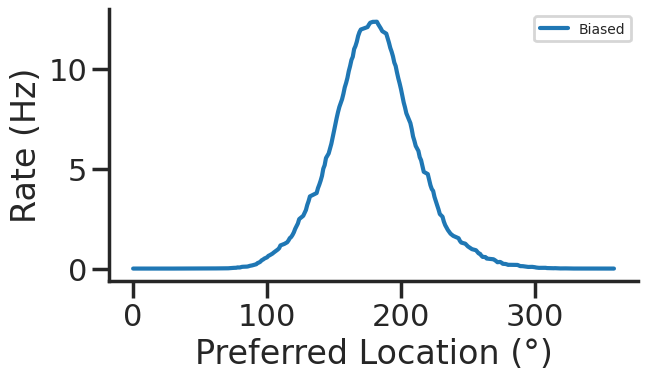

In [1]:
plt.plot(aligned_angles.cpu().numpy() * 180 / np.pi, population_tuning_curve.mean(dim=1).cpu().detach().numpy(), '-', label='Biased')
    if IF_BIAS:
        plt.plot(aligned_angles_.cpu().numpy() * 180 / np.pi, population_tuning_curve_.mean(dim=1).cpu().detach().numpy(), '-', label='Unbiased')

    plt.xlabel('Preferred Location (°)')
    plt.ylabel('Rate (Hz)')
    plt.legend(fontsize=10)
    plt.savefig('figs/christos/pop_tuning.svg', dpi=300)
    plt.show()

In [1]:
import torch
import numpy as np
from scipy.stats import skew

def calculate_width_and_skewness(mean_rates, angles):

    # Step 2: Unique angles and aggregate responses
    unique_angles, inverse_indices = torch.unique(angles, return_inverse=True)
    angle_responses = torch.zeros(len(unique_angles), mean_rates.size(1)).to(DEVICE)

    for i, angle_idx in enumerate(inverse_indices):
        angle_responses[angle_idx] += mean_rates[i]

    # Normalize by the count of each angle presentation
    angle_counts = torch.bincount(inverse_indices, minlength=len(unique_angles))
    angle_responses /= angle_counts.unsqueeze(1).float()

    # Initialize arrays for width and skewness
    width_estimates = torch.zeros(mean_rates.size(1)).to(DEVICE)
    skewness_estimates = torch.zeros(mean_rates.size(1)).to(DEVICE)

    # Calculate width and skewness for each neuron
    for neuron in range(mean_rates.size(1)):
        # Get responses
        responses = angle_responses[:, neuron]
        pref_idx = responses.argmax()
        pref = unique_angles[pref_idx]

        # Width estimate using FWHM
        peak_rate = torch.max(responses)
        half_max = peak_rate / 2

        # Find indices where response is greater than half max
        high_inds = torch.where(responses > half_max)[0]
        if len(high_inds) > 1:
            width_estimates[neuron] = unique_angles[high_inds[-1]] - unique_angles[high_inds[0]]

        # Skewness
        skewness_estimates[neuron] = skew(responses.cpu().detach().numpy())

    return width_estimates * 180 / torch.pi, skewness_estimates

tuning_width, skewness = calculate_width_and_skewness(mean_rates, angles)

In [1]:
import numpy as np

def compute_angular_skewness(mean_rates, angles):
    """
    Compute the skewness of tuning curves for given mean firing rates and angles.

    Parameters:
    - mean_rates: a list or array of mean firing rates for each angle.
    - angles: a list or array of angles in radians.

    Returns:
    - skewness: the computed skewness of the tuning curve.
    """
    # Convert angles to complex representation on the unit circle
    z = np.exp(1j * angles)

    # Compute the weighted mean direction
    R_total = np.sum(mean_rates)
    z_bar = np.sum(mean_rates * z) / R_total

    # Compute angular deviations
    delta_theta = np.angle(z * np.conj(z_bar))

    # Calculate weighted skewness
    numerator = np.sum(mean_rates * delta_theta**3)
    denominator = (R_total * (np.sum(mean_rates * delta_theta**2)))**1.5

    skewness = numerator / denominator if denominator != 0 else np.nan

    return skewness

# Example usage
# skewness = compute_angular_skewness(mean_rates.cpu().detach().numpy(), angles.cpu().detach().numpy())

In [1]:
import ineqpy

In [1]:
import torch
import numpy as np
from scipy.optimize import curve_fit

def gaussian(x, mu, sigma, amplitude):
    return amplitude * np.exp(-0.5 * ((x - mu) / sigma) ** 2)

def fit_gaussian_and_estimate_params(mean_rates, angles):
    # Rates is (N_BATCH, N_NEURONS, N_TIME)
    unique_angles, inverse_indices = np.unique(angles, return_inverse=True)
    angle_responses = np.zeros((len(unique_angles), mean_rates.shape[1]))

    for i, angle_idx in enumerate(inverse_indices):
        angle_responses[angle_idx] += mean_rates[i]

    # angle_counts = np.bincount(inverse_indices)
    # angle_responses /= angle_counts[:, None]

    width_estimates = np.zeros(mean_rates.shape[1])
    skewness_estimates = np.zeros(mean_rates.shape[1])

    # Fit Gaussian and calculate properties
    for neuron in range(mean_rates.shape[1]):
        responses = angle_responses[:, neuron]
        pref_idx = responses.argmax()
        pref = unique_angles[pref_idx]

        # Initial guess for Gaussian parameters
        initial_guess = [unique_angles[np.argmax(responses)], 1.0, responses.max()]

        # Fit Gaussian
        try:
            popt, _ = curve_fit(gaussian, unique_angles, responses, p0=initial_guess)
            mu, sigma, amplitude = popt

            # Save the width and inferred skewness
            width_estimates[neuron] = sigma

            # Skewness estimate can be derived from response distribution but Gaussian itself doesn't model skewness
            residuals = responses - gaussian(unique_angles, *popt)
            # skewness_estimates[neuron] = skew(residuals)
            # skewness_estimates[neuron] = skew(responses)
            # skewness_estimates[neuron] = compute_angular_skewness(responses, angles)
            ang = unique_angles - pref
            ang[ang>np.pi] -= 2 * np.pi
            ang[ang<-np.pi] += 2 * np.pi
            skewness_estimates[neuron] = ineqpy.statistics.skew(ang, responses)

        except RuntimeError:
            # Handle case where fit fails
            width_estimates[neuron] = np.nan
            skewness_estimates[neuron] = np.nan

    return width_estimates * 180 / np.pi, skewness_estimates

# Example usage

# tuning_width, skewness = fit_gaussian_and_estimate_params(mean_rates.cpu().detach().numpy(), angles.cpu().numpy())
tuning_width, skewness = fit_gaussian_and_estimate_params(normalized_rates, angles.cpu().numpy())

In [1]:
if IF_BIAS:
        pkl_save(tuning_width, 'tuning_width_bias', path="/home/leon/")
        pkl_save(skewness, 'skewness_bias', path="/home/leon/")

        tuning_width_ = pkl_load('tuning_width', path="/home/leon/")
        skewness_ = pkl_load('skewness', path="/home/leon/")
else:
        pkl_save(tuning_width, 'tuning_width', path="/home/leon/")
        pkl_save(skewness, 'skewness', path="/home/leon/")

saving to /home/leon//tuning_width.pkl
saving to /home/leon//skewness.pkl

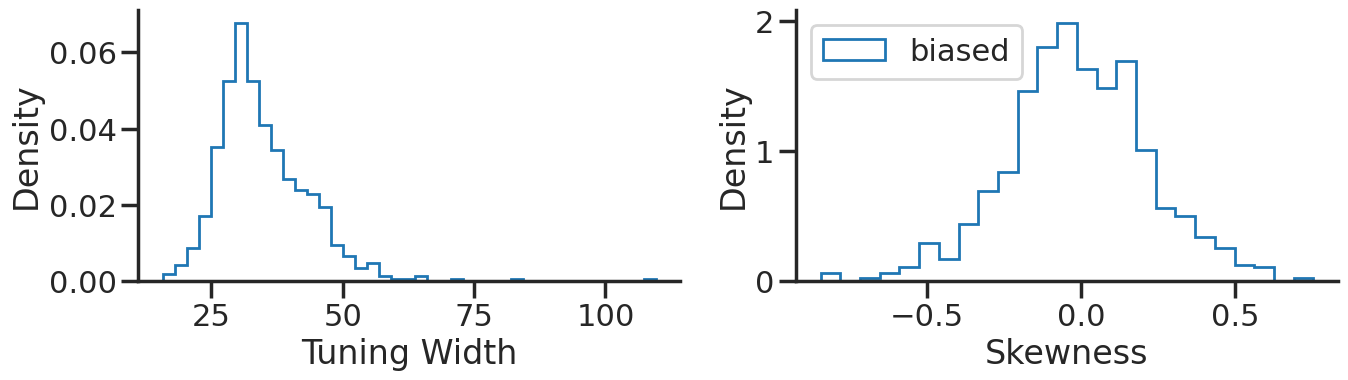

In [1]:
fig, ax = plt.subplots(1, 2, figsize=[2*width, height])

ax[0].hist(tuning_width, bins='auto', density=True, histtype='step')
ax[0].set_xlabel('Tuning Width')
ax[0].set_ylabel('Density')

ax[1].hist(skewness, bins='auto', density=True, histtype='step', label='biased')
ax[1].set_xlabel('Skewness')
ax[1].set_ylabel('Density')

if IF_BIAS:
    ax[0].hist(tuning_width_, bins='auto', density=True, histtype='step')
    ax[1].hist(skewness_, bins='auto', density=True, histtype='step', label='unbiased')

plt.legend()
plt.savefig('figs/christos/skewness.svg', dpi=300)
plt.show()

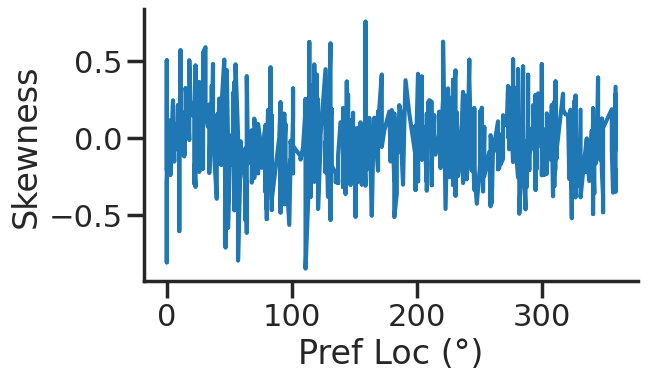

In [1]:
pref, indices = torch.sort(pref, descending=False)
plt.plot(pref.cpu().detach() * 180 / np.pi, skewness[indices.cpu().numpy()])
plt.plot(pref.cpu().detach()* 180 / np.pi, circcvl(skewness[indices.cpu().numpy()], windowSize=10))


if IF_BIAS:
    pref_, indices_ = torch.sort(pref_, descending=False)
    plt.plot(pref_.cpu().detach() * 180 / np.pi, skewness_[indices.cpu().numpy()])
    plt.plot(pref_.cpu().detach()* 180 / np.pi, circcvl(skewness_[indices_.cpu().numpy()], windowSize=10))

plt.xlabel('Pref Loc (°)')
plt.ylabel('Skewness')
plt.show()

In [1]:
if IF_BIAS:
    fig, ax = plt.subplots(1, 2, figsize=[2*height, height])

    # ax[0].scatter(tuning_width_, tuning_width)
    ax[0].set_xlabel('Unbiased Tuning Width')
    ax[0].set_ylabel('Biased Tuning Width')

    # ax[1].scatter(skewness_, skewness)
    ax[1].set_xlabel('Unbiased Skew')
    ax[1].set_ylabel('Biased Skew')

    plt.show()

In [1]:
if IF_BIAS:
        pkl_save(aligned_angles, 'aligned_angles_bias', path="/home/leon/")
        pkl_save(population_tuning_curve, 'population_tuning_curve_bias', path="/home/leon/")

        aligned_angles_ = pkl_load('aligned_angles', path="/home/leon/")
        population_tuning_curve_ = pkl_load('population_tuning_curve', path="/home/leon/")
else:
        pkl_save(aligned_angles, 'aligned_angles', path="/home/leon/")
        pkl_save(population_tuning_curve, 'population_tuning_curve', path="/home/leon/")

saving to /home/leon//aligned_angles.pkl
saving to /home/leon//population_tuning_curve.pkl